In [1]:
# Cell 1 - setup
# Install dependencies if not present. Kaggle often has these, but pip-install ensures availability.
!pip install --quiet kagglehub
!pip install --quiet tensorflow==2.12.0 scikit-learn matplotlib pandas tqdm

# Imports
import os
import random
import glob
import json
from pathlib import Path
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

import tensorflow as tf
from tensorflow.keras import layers, models, backend as K
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix

# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

print("TensorFlow version:", tf.__version__)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 586.0/586.0 MB 1.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 56.5 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 59.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 82.8 MB/s eta 0:00:00:00:01:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 17.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 19.6 MB/s eta 0:00:0000:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.7/440.7 kB 24.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.4/77.4 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.6/79.6 MB 22.2 MB/s eta 0:00:00:00:0100:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.12.0 requires google-cloud-bigquery-storage<3.0.0,>=2.3

In [2]:
# Cell 2 - load dataset files using kagglehub if available; adjust if you have local path

from kagglehub import KaggleDatasetAdapter, kagglehub

# Option A: use kagglehub to load dataset directory path
try:
    # Download dataset to a local path and return path
    dataset_path = kagglehub.dataset_download("bahushruth/legalclausedataset")
    print("Dataset unpacked to:", dataset_path)
    data_dir = Path(dataset_path)
except Exception as e:
    print("kagglehub.dataset_download failed:", e)
    # If you prefer to point directly to a local path (e.g., when running locally), set it below:
    # data_dir = Path(r"D:\Uni Work\SEM7\Deep Learning\A2\dataset")
    # For Kaggle, try reading from environment
    data_dir = Path("/kaggle/working/bahushruth-legalclausedataset")  # fallback
    print("Fallback data_dir:", data_dir)

# If the dataset path is a zip or nested, try to find CSVs under it
csv_files = list(data_dir.rglob("*.csv"))
if len(csv_files) == 0:
    # Try search one level deeper
    csv_files = list(data_dir.glob("**/*.csv"))

print(f"Found {len(csv_files)} csv files.")
# Print first 2 csv filenames and show their head
for i, f in enumerate(sorted(csv_files)[:2]):
    print(f"\n--- CSV #{i+1}: {f.name} ---")
    try:
        df_tmp = pd.read_csv(f, encoding='utf-8')
    except Exception as e:
        # sometimes quoting issues -> use engine python
        df_tmp = pd.read_csv(f, encoding='utf-8', engine='python')
    print(df_tmp.head(5))


Dataset unpacked to: /kaggle/input/legalclausedataset
Found 395 csv files.

--- CSV #1: absence-of-certain-changes-or-events.csv ---
                                         clause_text  \
0  Absence of Certain Changes or Events. Except a...   
1  Absence of Certain Changes or Events. Since Ma...   
2  Absence of Certain Changes or Events. (a) Sinc...   
3  Absence of Certain Changes or Events. Since th...   
4  Absence of Certain Changes or Events. Except a...   

                            clause_type  
0  absence-of-certain-changes-or-events  
1  absence-of-certain-changes-or-events  
2  absence-of-certain-changes-or-events  
3  absence-of-certain-changes-or-events  
4  absence-of-certain-changes-or-events  

--- CSV #2: absence-of-certain-changes.csv ---
                                         clause_text  \
0  Absence of Certain Changes. There have been no...   
1  Absence of Certain Changes. Since September 30...   
2  Absence of Certain Changes. Since December 31,...   
3  Abs

In [3]:
# Cell 3 - read all clause CSVs into single dataframe
def load_clause_csvs(csv_paths):
    dfs = []
    for p in tqdm(sorted(csv_paths), desc="Loading CSVs"):
        try:
            df = pd.read_csv(p, encoding='utf-8')
        except Exception:
            df = pd.read_csv(p, encoding='utf-8', engine='python')
        # Ensure expected columns exist; if not, infer
        cols = [c.strip().lower() for c in df.columns]
        # Normalize column names
        rename_map = {}
        for c in df.columns:
            lc = c.strip().lower()
            if 'clause_text' in lc or 'text' == lc or 'clause' == lc:
                rename_map[c] = 'clause_text'
            if 'clause_type' in lc or 'type' == lc or 'label' == lc:
                rename_map[c] = 'clause_type'
        df = df.rename(columns=rename_map)
        if 'clause_text' not in df.columns:
            # try first column
            df = df.rename(columns={df.columns[0]: 'clause_text'})
        if 'clause_type' not in df.columns:
            # infer from file name
            df['clause_type'] = Path(p).stem
        # Drop NA and keep only text & type
        df = df[['clause_text', 'clause_type']].dropna().reset_index(drop=True)
        dfs.append(df)
    combined = pd.concat(dfs, ignore_index=True)
    return combined

clauses_df = load_clause_csvs(csv_files)
print("Total clauses loaded:", len(clauses_df))
print("Clause types distribution:")
print(clauses_df['clause_type'].value_counts().head(20))


Loading CSVs:   0%|          | 0/395 [00:00<?, ?it/s]

Total clauses loaded: 150881
Clause types distribution:
clause_type
time-of-essence                          630
time-of-the-essence                      620
capitalized-terms                        590
definitions-and-interpretation           590
captions                                 580
headings                                 570
section-headings                         570
now-therefore                            570
exhibits                                 570
definitions                              560
defined-terms                            560
financial-covenants                      560
certain-defined-terms                    550
name                                     540
currency                                 540
covenants-of-the-company                 540
effective-date                           530
special-terms-and-conditions-of-trust    530
conditions-to-effectiveness              530
conditions-precedent                     520
Name: count, dtype: int64


In [4]:
# Cell 4 - preprocessing helpers

import re
def clean_text(s):
    if not isinstance(s, str):
        s = str(s)
    # Remove wrapping quotes if present
    s = s.strip()
    if (s.startswith('"') and s.endswith('"')) or (s.startswith("'") and s.endswith("'")):
        s = s[1:-1].strip()
    # Normalize whitespace
    s = re.sub(r'\s+', ' ', s)
    # Replace long numbers / times etc. optionally keep, but normalize digits
    s = re.sub(r'\d{2}:\d{2}:\d{2}', ' <TIME> ', s)  # map times
    s = re.sub(r'\d+', ' <NUM> ', s)
    # Lowercase
    s = s.lower()
    # Remove repeated spaces
    s = re.sub(r'\s+', ' ', s).strip()
    return s

# Apply cleaning
clauses_df['clause_text_clean'] = clauses_df['clause_text'].astype(str).apply(clean_text)
# Show a few examples
clauses_df[['clause_text', 'clause_text_clean', 'clause_type']].head(6)


,clause_text,clause_text_clean,clause_type
0,Absence of Certain Changes or Events. Except a...,absence of certain changes or events. except a...,absence-of-certain-changes-or-events
1,Absence of Certain Changes or Events. Since Ma...,absence of certain changes or events. since ma...,absence-of-certain-changes-or-events
2,Absence of Certain Changes or Events. (a) Sinc...,absence of certain changes or events. (a) sinc...,absence-of-certain-changes-or-events
3,Absence of Certain Changes or Events. Since th...,absence of certain changes or events. since th...,absence-of-certain-changes-or-events
4,Absence of Certain Changes or Events. Except a...,absence of certain changes or events. except a...,absence-of-certain-changes-or-events
5,Absence of Certain Changes or Events. Since Ma...,absence of certain changes or events. since ma...,absence-of-certain-changes-or-events


In [5]:
# Cell 5 - create pairs
# We'll create positive pairs by sampling pairs within the same clause_type,
# and negative pairs by sampling pairs from different types.
# For tractability, limit per-type samples.

from itertools import combinations
def generate_pairs(df, max_pos_pairs_per_type=2000, neg_multiplier=1.0, max_total_pairs=50000):
    grouped = df.groupby('clause_type')['clause_text_clean'].apply(list).to_dict()
    pos_pairs = []
    # Positive pairs
    for t, texts in grouped.items():
        n = len(texts)
        if n < 2:
            continue
        # If a type has many examples, sample subset of indices for pair generation
        idxs = list(range(n))
        # sample size to limit explosion
        sample_k = min(n, 200)  # choose up to 200 samples from each type for pair generation
        sampled = random.sample(idxs, sample_k)
        # create random pairs among sampled indices
        combos = list(combinations(sampled, 2))
        random.shuffle(combos)
        take = min(len(combos), max_pos_pairs_per_type)
        for a,b in combos[:take]:
            pos_pairs.append((texts[a], texts[b], 1))
    # Negative pairs: sample pairs from different types
    neg_pairs = []
    types = list(grouped.keys())
    # Flatten a reduced list for negative sampling
    small_pool = []
    for t, texts in grouped.items():
        take = min(len(texts), 100)
        small_pool.extend([(t, txt) for txt in random.sample(texts, take)])
    # sample negatives by pairing texts from different types
    target_neg_count = int(len(pos_pairs) * neg_multiplier)
    tries = 0
    while len(neg_pairs) < target_neg_count and tries < target_neg_count * 10:
        a = random.choice(small_pool)
        b = random.choice(small_pool)
        tries += 1
        if a[0] != b[0]:
            neg_pairs.append((a[1], b[1], 0))
    # combine and shuffle, cap to max_total_pairs
    all_pairs = pos_pairs + neg_pairs
    random.shuffle(all_pairs)
    if len(all_pairs) > max_total_pairs:
        all_pairs = all_pairs[:max_total_pairs]
    pairs_df = pd.DataFrame(all_pairs, columns=['text_a', 'text_b', 'label'])
    return pairs_df

pairs = generate_pairs(clauses_df, max_pos_pairs_per_type=800, neg_multiplier=1.0, max_total_pairs=40000)
print("Pairs generated:", len(pairs))
print("Label distribution:\n", pairs['label'].value_counts())
pairs.head(6)


Pairs generated: 40000
Label distribution:
 label
0    20054
1    19946
Name: count, dtype: int64


,text_a,text_b,label
0,entire agreement; amendment. this escrow agree...,default. each of the following events shall co...,0
1,termination without cause. company also may te...,compensation. for the services provided hereun...,0
2,restrictive covenants. (a) for a period of twe...,restrictive covenants. it cruise is not a part...,1
3,redemption. t+ <num> r <num> . <num> prior to ...,w i t n e s s e t h whereas the seller is the ...,0
4,terms. the terms of such extended loans shall ...,subsidiaries. <num> . <num> (a) ucc filing jur...,0
5,special terms and conditions of trust. tarantu...,binding effect. this agreement inures to the b...,0


In [6]:
# Cell 6 - splits and tokenizer
train_df, test_df = train_test_split(pairs, test_size=0.15, random_state=SEED, stratify=pairs['label'])
train_df, val_df = train_test_split(train_df, test_size=0.15, random_state=SEED, stratify=train_df['label'])

print("Train / Val / Test sizes:", len(train_df), len(val_df), len(test_df))

# Tokenizer on combined text
MAX_VOCAB = 30000
tokenizer = Tokenizer(num_words=MAX_VOCAB, oov_token='<OOV>')
all_texts = pd.concat([pairs['text_a'], pairs['text_b']])
tokenizer.fit_on_texts(all_texts)

# Save tokenizer for later use
word_index = tokenizer.word_index
print("Vocabulary size (unique tokens in tokenizer):", len(word_index))


Train / Val / Test sizes: 28900 5100 6000
Vocabulary size (unique tokens in tokenizer): 28743


In [7]:
# Cell 7 - seq conversion
MAX_LEN = 256  # you can adjust based on average length

def texts_to_padded_seqs(tokenizer, texts, maxlen=MAX_LEN):
    seqs = tokenizer.texts_to_sequences(texts)
    return pad_sequences(seqs, maxlen=maxlen, padding='post', truncating='post')

def df_to_model_inputs(df):
    A = texts_to_padded_seqs(tokenizer, df['text_a'].tolist())
    B = texts_to_padded_seqs(tokenizer, df['text_b'].tolist())
    y = df['label'].astype('float32').values
    return (A, B), y

(xA_train, xB_train), y_train = df_to_model_inputs(train_df)
(xA_val, xB_val), y_val = df_to_model_inputs(val_df)
(xA_test, xB_test), y_test = df_to_model_inputs(test_df)

print("Shapes:", xA_train.shape, xB_train.shape, y_train.shape)


Shapes: (28900, 256) (28900, 256) (28900,)


In [8]:
# Cell 8 - attention layer and model builders

class AttentionLayer(layers.Layer):
    def __init__(self, units):
        super().__init__()
        self.W = layers.Dense(units)
        self.V = layers.Dense(1)
    def call(self, features):
        # features: (batch, time, dim)
        score = tf.nn.tanh(self.W(features))  # (batch, time, units)
        attention_weights = tf.nn.softmax(self.V(score), axis=1)  # (batch, time, 1)
        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)  # (batch, dim)
        return context_vector, attention_weights

def build_siamese_bilstm(vocab_size, embedding_dim=200, maxlen=MAX_LEN, lstm_units=128, dense_units=128, dropout=0.3):
    # Shared embedding + BiLSTM encoder
    inp = layers.Input(shape=(maxlen,), name='text_input')
    x = layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=maxlen, mask_zero=True)(inp)
    x = layers.Bidirectional(layers.LSTM(lstm_units, return_sequences=False))(x)  # outputs vector
    x = layers.Dropout(dropout)(x)
    encoder = models.Model(inp, x, name='siamese_encoder')
    
    # two inputs
    in_a = layers.Input(shape=(maxlen,), name='in_a')
    in_b = layers.Input(shape=(maxlen,), name='in_b')
    vec_a = encoder(in_a)
    vec_b = encoder(in_b)
    # Combine features: absolute difference and multiply and concat
    diff = layers.Lambda(lambda tensors: K.abs(tensors[0] - tensors[1]))([vec_a, vec_b])
    mult = layers.Multiply()([vec_a, vec_b])
    merged = layers.Concatenate()([vec_a, vec_b, diff, mult])
    x = layers.Dense(dense_units, activation='relu')(merged)
    x = layers.Dropout(dropout)(x)
    x = layers.Dense(dense_units//2, activation='relu')(x)
    out = layers.Dense(1, activation='sigmoid')(x)
    model = models.Model([in_a, in_b], out, name='siamese_bilstm')
    return model

def build_attention_bilstm(vocab_size, embedding_dim=200, maxlen=MAX_LEN, lstm_units=128, attn_units=64, dense_units=128, dropout=0.3):
    # encoder with BiLSTM return_sequences + attention pooling
    inp = layers.Input(shape=(maxlen,), name='text_input')
    x = layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=maxlen, mask_zero=True)(inp)
    x = layers.Bidirectional(layers.LSTM(lstm_units, return_sequences=True))(x)  # seq outputs
    context, attn = AttentionLayer(attn_units)(x)
    encoder = models.Model(inp, context, name='attn_encoder')
    
    in_a = layers.Input(shape=(maxlen,), name='in_a')
    in_b = layers.Input(shape=(maxlen,), name='in_b')
    vec_a = encoder(in_a)
    vec_b = encoder(in_b)
    merged = layers.Concatenate()([vec_a, vec_b, layers.Lambda(lambda x: K.abs(x[0]-x[1]))([vec_a, vec_b])])
    x = layers.Dense(dense_units, activation='relu')(merged)
    x = layers.Dropout(dropout)(x)
    x = layers.Dense(dense_units//2, activation='relu')(x)
    out = layers.Dense(1, activation='sigmoid')(x)
    model = models.Model([in_a, in_b], out, name='attention_bilstm')
    return model


In [9]:
# Cell 9 - build models
vocab_size = min(MAX_VOCAB, len(word_index) + 1)

siamese_model = build_siamese_bilstm(vocab_size=vocab_size, embedding_dim=200, lstm_units=128, dense_units=128)
attn_model = build_attention_bilstm(vocab_size=vocab_size, embedding_dim=200, lstm_units=128, attn_units=64, dense_units=128)

siamese_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
attn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

print("Siamese model summary:")
siamese_model.summary()
print("\nAttention model summary:")
attn_model.summary()


Siamese model summary:
Model: "siamese_bilstm"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 in_a (InputLayer)              [(None, 256)]        0           []                               
                                                                                                  
 in_b (InputLayer)              [(None, 256)]        0           []                               
                                                                                                  
 siamese_encoder (Functional)   (None, 256)          6085696     ['in_a[0][0]',                   
                                                                  'in_b[0][0]']                   
                                                                                                  
 lambda (Lambda)                (None, 256)          0        

In [10]:
# Cell 10 - training helper functions and callbacks
BATCH_SIZE = 128
EPOCHS = 10

def get_callbacks(model_name):
    ckpt_path = f"/kaggle/working/{model_name}_best.h5"
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1),
        ModelCheckpoint(ckpt_path, monitor='val_loss', save_best_only=True, verbose=1),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1)
    ]
    return callbacks

# Train siamese model
history_siamese = siamese_model.fit(
    [xA_train, xB_train], y_train,
    validation_data=([xA_val, xB_val], y_val),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=get_callbacks("siamese"),
    verbose=2
)


Epoch 1/10

Epoch 1: val_loss improved from inf to 0.06237, saving model to /kaggle/working/siamese_best.h5
226/226 - 445s - loss: 0.2534 - accuracy: 0.8804 - val_loss: 0.0624 - val_accuracy: 0.9816 - lr: 0.0010 - 445s/epoch - 2s/step
Epoch 2/10

Epoch 2: val_loss did not improve from 0.06237
226/226 - 445s - loss: 0.0183 - accuracy: 0.9951 - val_loss: 0.0906 - val_accuracy: 0.9724 - lr: 0.0010 - 445s/epoch - 2s/step
Epoch 3/10

Epoch 3: val_loss improved from 0.06237 to 0.05576, saving model to /kaggle/working/siamese_best.h5
226/226 - 420s - loss: 0.0113 - accuracy: 0.9965 - val_loss: 0.0558 - val_accuracy: 0.9857 - lr: 0.0010 - 420s/epoch - 2s/step
Epoch 4/10

Epoch 4: val_loss did not improve from 0.05576
226/226 - 424s - loss: 0.0107 - accuracy: 0.9965 - val_loss: 0.0591 - val_accuracy: 0.9863 - lr: 0.0010 - 424s/epoch - 2s/step
Epoch 5/10

Epoch 5: val_loss improved from 0.05576 to 0.05457, saving model to /kaggle/working/siamese_best.h5
226/226 - 430s - loss: 0.0067 - accuracy: 

In [11]:
# Cell 11 - train attention-based model
history_attn = attn_model.fit(
    [xA_train, xB_train], y_train,
    validation_data=([xA_val, xB_val], y_val),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=get_callbacks("attn"),
    verbose=2
)


Epoch 1/10

Epoch 1: val_loss improved from inf to 0.02654, saving model to /kaggle/working/attn_best.h5
226/226 - 487s - loss: 0.4531 - accuracy: 0.7301 - val_loss: 0.0265 - val_accuracy: 0.9933 - lr: 0.0010 - 487s/epoch - 2s/step
Epoch 2/10

Epoch 2: val_loss improved from 0.02654 to 0.00837, saving model to /kaggle/working/attn_best.h5
226/226 - 475s - loss: 0.0119 - accuracy: 0.9973 - val_loss: 0.0084 - val_accuracy: 0.9986 - lr: 0.0010 - 475s/epoch - 2s/step
Epoch 3/10

Epoch 3: val_loss improved from 0.00837 to 0.00680, saving model to /kaggle/working/attn_best.h5
226/226 - 473s - loss: 0.0053 - accuracy: 0.9991 - val_loss: 0.0068 - val_accuracy: 0.9988 - lr: 0.0010 - 473s/epoch - 2s/step
Epoch 4/10

Epoch 4: val_loss improved from 0.00680 to 0.00665, saving model to /kaggle/working/attn_best.h5
226/226 - 499s - loss: 0.0024 - accuracy: 0.9995 - val_loss: 0.0066 - val_accuracy: 0.9992 - lr: 0.0010 - 499s/epoch - 2s/step
Epoch 5/10

Epoch 5: val_loss did not improve from 0.00665
2

Siamese training curves:


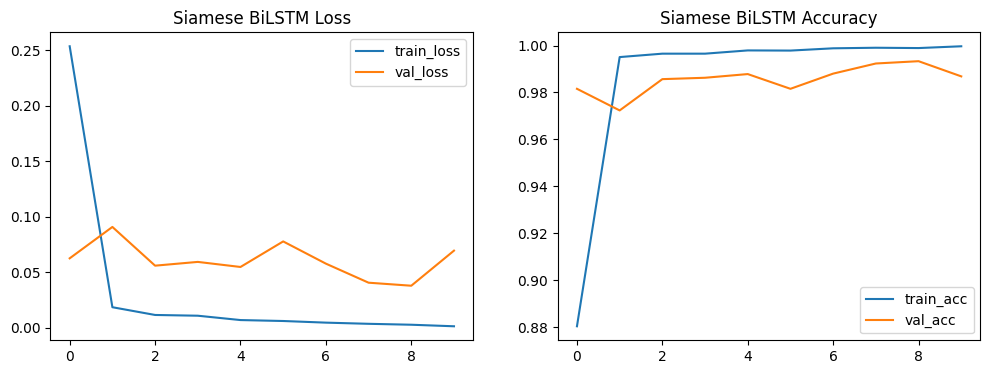

Attention model training curves:


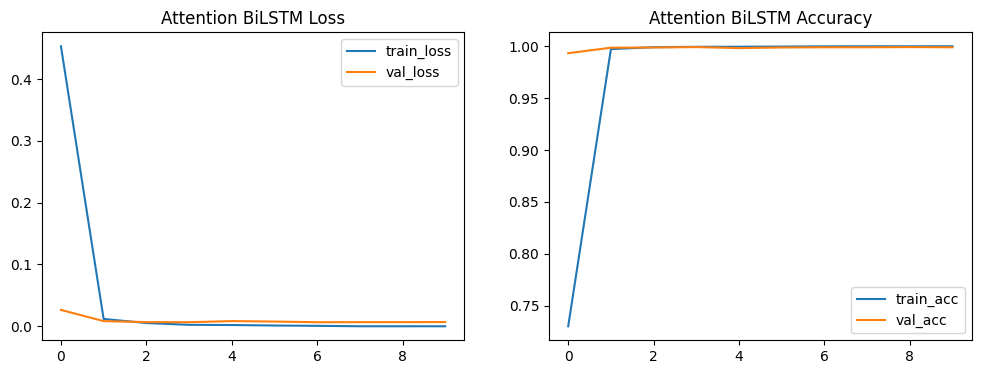

In [12]:
# Cell 12 - plot training graphs
def plot_history(h, title):
    plt.figure(figsize=(12,4))
    # loss
    plt.subplot(1,2,1)
    plt.plot(h.history['loss'], label='train_loss')
    plt.plot(h.history['val_loss'], label='val_loss')
    plt.title(f"{title} Loss")
    plt.legend()
    # acc
    plt.subplot(1,2,2)
    if 'accuracy' in h.history:
        plt.plot(h.history['accuracy'], label='train_acc')
        plt.plot(h.history['val_accuracy'], label='val_acc')
    else:
        plt.plot(h.history.get('acc', []), label='train_acc')
        plt.plot(h.history.get('val_acc', []), label='val_acc')
    plt.title(f"{title} Accuracy")
    plt.legend()
    plt.show()

print("Siamese training curves:")
plot_history(history_siamese, "Siamese BiLSTM")
print("Attention model training curves:")
plot_history(history_attn, "Attention BiLSTM")


In [13]:
# Cell 13 - evaluation functions
def evaluate_model(model, xA, xB, y_true, threshold=0.5):
    y_prob = model.predict([xA, xB], batch_size=256).ravel()
    y_pred = (y_prob >= threshold).astype(int)
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    try:
        roc = roc_auc_score(y_true, y_prob)
    except ValueError:
        roc = float('nan')
    return {'acc': acc, 'precision': prec, 'recall': rec, 'f1': f1, 'roc_auc': roc, 'y_prob': y_prob, 'y_pred': y_pred}

print("Evaluating Siamese model on test set...")
res_siam = evaluate_model(siamese_model, xA_test, xB_test, y_test)
print(res_siam)

print("Evaluating Attention model on test set...")
res_attn = evaluate_model(attn_model, xA_test, xB_test, y_test)
print(res_attn)

# Show classification reports
print("\nSiamese classification report:")
print(classification_report(y_test, res_siam['y_pred'], digits=4))
print("\nAttention classification report:")
print(classification_report(y_test, res_attn['y_pred'], digits=4))


Evaluating Siamese model on test set...
24/24 [==============================] - 28s 993ms/step
{'acc': 0.9866666666666667, 'precision': 0.9739583333333334, 'recall': 1.0, 'f1': 0.9868073878627968, 'roc_auc': 0.9989381035598475, 'y_prob': array([1.0000000e+00, 6.4480503e-07, 1.9606946e-07, ..., 1.4162442e-06,
       1.0000000e+00, 2.1725047e-07], dtype=float32), 'y_pred': array([1, 0, 0, ..., 0, 1, 0])}
Evaluating Attention model on test set...
24/24 [==============================] - 33s 1s/step
{'acc': 0.9988333333333334, 'precision': 0.997997997997998, 'recall': 0.9996657754010695, 'f1': 0.9988311905159458, 'roc_auc': 0.9995863303916829, 'y_prob': array([9.9998617e-01, 2.5914810e-06, 8.5612091e-06, ..., 2.6482446e-06,
       9.9996418e-01, 5.5847959e-06], dtype=float32), 'y_pred': array([1, 0, 0, ..., 0, 1, 0])}

Siamese classification report:
              precision    recall  f1-score   support

         0.0     1.0000    0.9734    0.9865      3008
         1.0     0.9740    1.000

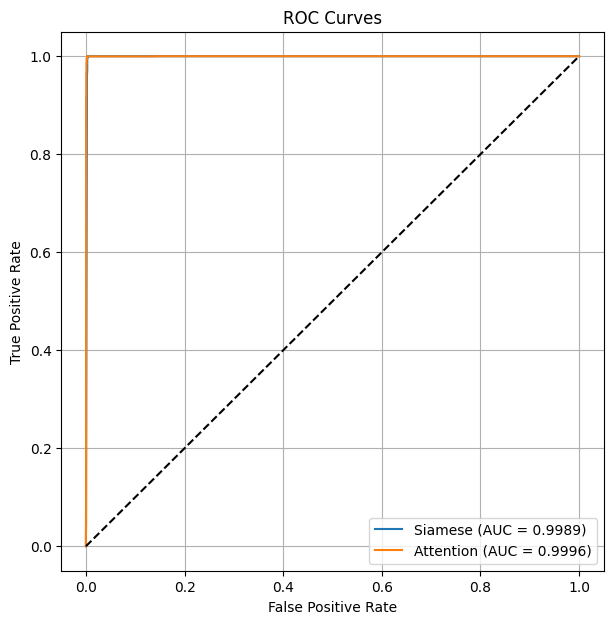

              model  accuracy  precision    recall        f1   roc_auc
0    siamese_bilstm  0.986667   0.973958  1.000000  0.986807  0.998938
1  attention_bilstm  0.998833   0.997998  0.999666  0.998831  0.999586


In [ ]:
# Cell 14 - ROC plots and table
from sklearn.metrics import roc_curve, auc

def plot_roc(y_true, y_prob, name):
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.4f})')

plt.figure(figsize=(7,7))
plot_roc(y_test, res_siam['y_prob'], 'Siamese')
plot_roc(y_test, res_attn['y_prob'], 'Attention')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()
plt.grid(True)
plt.show()

# Performance summary table
summary = pd.DataFrame({
    'model': ['siamese_bilstm', 'attention_bilstm'],
    'accuracy': [res_siam['acc'], res_attn['acc']],
    'precision': [res_siam['precision'], res_attn['precision']],
    'recall': [res_siam['recall'], res_attn['recall']],
    'f1': [res_siam['f1'], res_attn['f1']],
    'roc_auc': [res_siam['roc_auc'], res_attn['roc_auc']],
})
print(summary)


In [ ]:
# Cell 15 - qualitative examples
def show_examples(df_pairs, y_prob, y_pred, y_true, n=5, tag='correct'):
    # df_pairs corresponds to test_df
    df = df_pairs.copy().reset_index(drop=True)
    df['y_prob'] = y_prob
    df['y_pred'] = y_pred
    df['y_true'] = y_true
    if tag == 'correct':
        sel = df[df['y_pred'] == df['y_true']]
    elif tag == 'incorrect':
        sel = df[df['y_pred'] != df['y_true']]
    else:
        sel = df
    return sel.sample(n=min(n, len(sel)), random_state=SEED)

test_pairs_df = test_df.reset_index(drop=True).copy()

print("Siamese - Correct examples:")
display(show_examples(test_pairs_df, res_siam['y_prob'], res_siam['y_pred'], y_test, n=5, tag='correct')[['text_a','text_b','y_true','y_pred','y_prob']])

print("Siamese - Incorrect examples:")
display(show_examples(test_pairs_df, res_siam['y_prob'], res_siam['y_pred'], y_test, n=5, tag='incorrect')[['text_a','text_b','y_true','y_pred','y_prob']])

print("Attention - Correct examples:")
display(show_examples(test_pairs_df, res_attn['y_prob'], res_attn['y_pred'], y_test, n=5, tag='correct')[['text_a','text_b','y_true','y_pred','y_prob']])

print("Attention - Incorrect examples:")
display(show_examples(test_pairs_df, res_attn['y_prob'], res_attn['y_pred'], y_test, n=5, tag='incorrect')[['text_a','text_b','y_true','y_pred','y_prob']])


Siamese - Correct examples:


,text_a,text_b,y_true,y_pred,y_prob
4865,interpretation. any ambiguity in this schedule...,records. the managing gp will:,0.0,0,0.000009
1287,"right of setoff. each purchaser may, and is he...",right of setoff. comdata shall have the right ...,1.0,1,1.000000
4138,duration of agreement. a. this agreement shall...,duration of agreement. <num> . <num> this agre...,1.0,1,1.000000
5130,disputes. in the event of a dispute between th...,"disputes. it is understood and agreed that, up...",1.0,1,1.000000
4065,defaults. no default or event of default exist...,defaults. there has not been any material defa...,1.0,1,1.000000


Siamese - Incorrect examples:


,text_a,text_b,y_true,y_pred,y_prob
2089,severability. if any term or provision of this...,ownership. the stockholder is the sole benefic...,0.0,1,0.606188
102,adjustments. the number and kind of shares of ...,arbitration. any controversy of claim arising ...,0.0,1,0.518240
1593,"salary. for services to be rendered hereunder,...",employee benefits. (a) schedule <num> . <num> ...,0.0,1,0.579940
2222,exercise of option. the exercise of the option...,grant of option. subject to the terms and cond...,0.0,1,1.000000
1180,investment company. the company represents and...,"survival. all covenants, agreements, represent...",0.0,1,0.949084


Attention - Correct examples:


,text_a,text_b,y_true,y_pred,y_prob
2407,"defaults. there has not been any default, or t...",the closing. unless otherwise mutually agreed ...,0.0,0,1.607830e-07
1919,no waiver. the failure or delay of any party t...,environmental matters. except as could not rea...,0.0,0,3.410342e-06
2507,non-solicitation. the seller shall not take an...,non-solicitation. in the event the purchaser c...,1.0,1,9.999959e-01
2517,counterparts. this agreement may be executed i...,counterparts. this agreement may be executed i...,1.0,1,9.999987e-01
2027,power of attorney. seller does hereby irrevoca...,conditions. the effectiveness of this loan mod...,0.0,0,8.027311e-11


Attention - Incorrect examples:


,text_a,text_b,y_true,y_pred,y_prob
1106,termination without cause. employer may termin...,termination of employment. (a) the employee's ...,0.0,1,0.999888
1577,waiver of past defaults. so long as no insurer...,waiver of jury trial. racer and elio hereby kn...,0.0,1,1.000000
3944,"compliance certificate. at the closing, compan...",compliance with laws. target has complied with...,0.0,1,0.996481
1838,disputes. conflicts and disagreements between ...,disputes. <num> termination and remedies,1.0,0,0.000021
3661,registration rights. if (but without any oblig...,registration. the company shall maintain books...,0.0,1,0.997335


In [17]:
# Cell 16 - save artifacts
import pickle
artifacts_dir = Path("/kaggle/working/artifacts")
artifacts_dir.mkdir(parents=True, exist_ok=True)

# Save model architecture (JSON)
with open(artifacts_dir / "siamese_model_architecture.json", "w") as f:
    f.write(siamese_model.to_json())

with open(artifacts_dir / "attn_model_architecture.json", "w") as f:
    f.write(attn_model.to_json())

# Save weights only
siamese_model.save_weights(artifacts_dir / "siamese_model_weights.h5")
attn_model.save_weights(artifacts_dir / "attn_model_weights.h5")

# Save tokenizer
with open(artifacts_dir / "tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)

# Save summary CSV
summary.to_csv(artifacts_dir / "model_performance_summary.csv", index=False)

print("✅ Artifacts saved successfully in:", artifacts_dir)



✅ Artifacts saved successfully in: /kaggle/working/artifacts
